## Import

In [61]:
import tensorflow as tf
import tensorflow_datasets as tfds

import random
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# create confusion matrix
import itertools
from sklearn.metrics import confusion_matrix

## Functions

In [2]:
def normalize(images, labels):
  images = tf.cast(images, tf.float32)
  images /= 255.0
  return images, labels

def plot_image(i, predictions_array, true_labels, images, class_names):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

def plot_graphs(title, history, string):
  plt.title(title)
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

def plot_results(title, history):
  plot_graphs(title, history, "accuracy")
  plot_graphs(title, history, "loss")

In [81]:
# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [4]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

## Download the Fashion MNIST dataset from TFDS

In [5]:
(train_data, validation_data, test_data), info = tfds.load(
    'fashion_mnist',
    as_supervised=True,
    with_info=True,
    split=['train[:70%]', 'train[70%:]', 'test']
)

Loading the dataset returns metadata as well as a *training dataset* and *test dataset*.

* The model is trained using `train_dataset`.
* The model is tested against `test_dataset`.

The images are 28 $\times$ 28 arrays, with pixel values in the range `[0, 255]`. The *labels* are an array of integers, in the range `[0, 9]`. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

In [63]:
class_names = info.features['label'].names
print("Class names: {}".format(class_names))
print("Total: {} classes".format(len(class_names)))

#num_train = info.splits['train'].num_examples
#num_test = info.splits['test'].num_examples
num_train = len(train_data)
num_validation = len(validation_data)
num_test = len(test_data)
print("Number of training data:   {}".format(num_train))
print("Number of validation data: {}".format(num_validation))
print("Number of test data:       {}".format(num_test))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Total: 10 classes
Number of training data:   42000
Number of validation data: 18000
Number of test data:       10000


## Preprocess the data

The value of each pixel in the image data is an integer in the range `[0,255]`. For the model to work properly, these values need to be normalized to the range `[0,1]`. So here we create a normalization function, and then apply it to each image in the test and train datasets.

In [7]:
train_data =  train_data.map(normalize)
validation_data =  validation_data.map(normalize)
test_data  =  test_data.map(normalize)

## Preview the data

### random preview

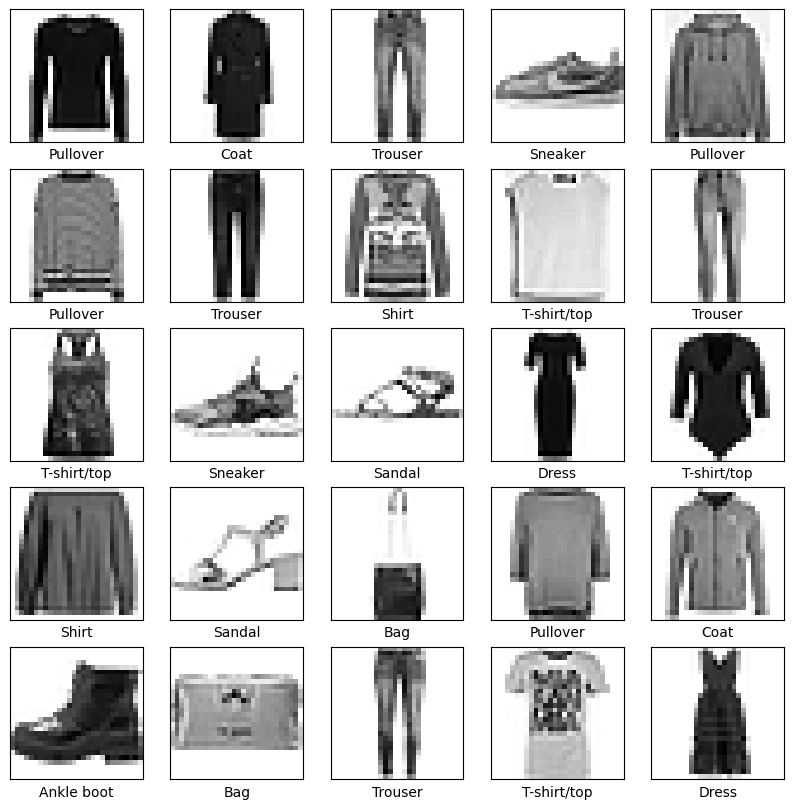

In [8]:
plt.figure(figsize=(10, 10))
i = 0
for i, (image, label) in enumerate(train_data.shuffle(100).take(25)):
    #image = image.numpy().reshape((28, 28))
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()

## Batch the data

In [79]:
BATCH_SIZE = 1024

train_batches = train_data.shuffle(10000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_batches = validation_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_batches = test_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## Build the model

### Get the best learning rate

In [80]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20)
)

history = model.fit(
    train_batches,
    epochs=50,
    validation_data=validation_batches,
    callbacks=[lr_schedule]
)

Epoch 1/50
42/42 [==============================] - 4s 57ms/step - loss: 2.0477 - accuracy: 0.2764 - val_loss: 1.7022 - val_accuracy: 0.5636 - lr: 1.0000e-04
Epoch 2/50
42/42 [==============================] - 2s 49ms/step - loss: 1.4430 - accuracy: 0.4730 - val_loss: 1.1309 - val_accuracy: 0.6302 - lr: 1.1220e-04
Epoch 3/50
42/42 [==============================] - 2s 51ms/step - loss: 1.1602 - accuracy: 0.5535 - val_loss: 0.9454 - val_accuracy: 0.6716 - lr: 1.2589e-04
Epoch 4/50
42/42 [==============================] - 2s 51ms/step - loss: 1.0262 - accuracy: 0.6098 - val_loss: 0.8343 - val_accuracy: 0.7067 - lr: 1.4125e-04
Epoch 5/50
42/42 [==============================] - 2s 51ms/step - loss: 0.9183 - accuracy: 0.6631 - val_loss: 0.7384 - val_accuracy: 0.7416 - lr: 1.5849e-04
Epoch 6/50
42/42 [==============================] - 2s 52ms/step - loss: 0.8365 - accuracy: 0.6953 - val_loss: 0.6671 - val_accuracy: 0.7716 - lr: 1.7783e-04
Epoch 7/50
42/42 [==============================] - 

### Plot the history

<Axes: xlabel='epochs'>

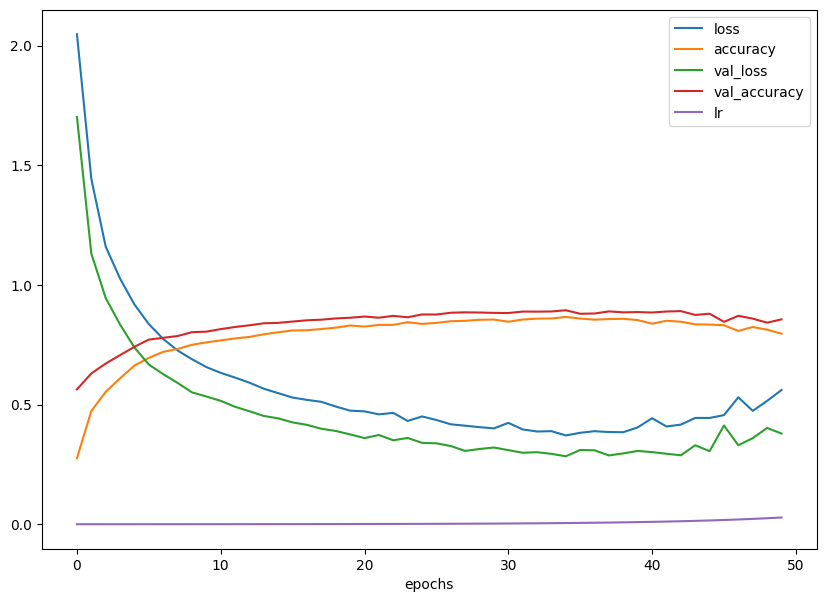

In [82]:
pd.DataFrame(history.history).plot(figsize=(10, 7), xlabel='epochs')

### Plot the Learning rate vs. Loss

Text(0.5, 1.0, 'Learning rate vs. Loss')

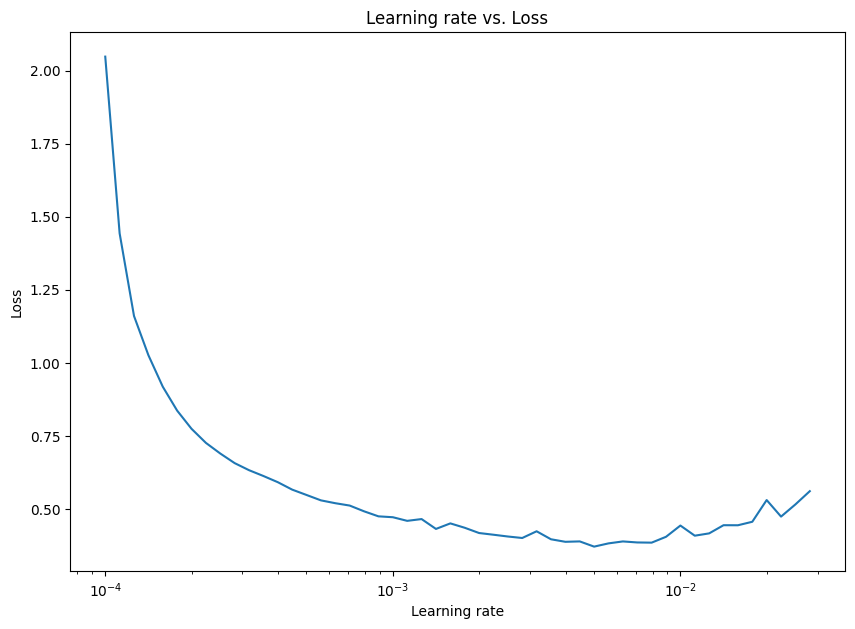

In [83]:
plt.figure(figsize=(10, 7))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.xlabel('Learning rate')
plt.ylabel('Loss')
plt.title('Learning rate vs. Loss')

### Train the Model with the best learning rate

In [84]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

history = model.fit(
    train_batches,
    epochs=20,
    validation_data=validation_batches
)

Epoch 1/20
42/42 [==============================] - 3s 56ms/step - loss: 1.2345 - accuracy: 0.5373 - val_loss: 0.6656 - val_accuracy: 0.7651
Epoch 2/20
42/42 [==============================] - 2s 51ms/step - loss: 0.6983 - accuracy: 0.7440 - val_loss: 0.5240 - val_accuracy: 0.8116
Epoch 3/20
42/42 [==============================] - 2s 51ms/step - loss: 0.5984 - accuracy: 0.7795 - val_loss: 0.4757 - val_accuracy: 0.8319
Epoch 4/20
42/42 [==============================] - 2s 51ms/step - loss: 0.5608 - accuracy: 0.7959 - val_loss: 0.4426 - val_accuracy: 0.8390
Epoch 5/20
42/42 [==============================] - 2s 51ms/step - loss: 0.5305 - accuracy: 0.8060 - val_loss: 0.4174 - val_accuracy: 0.8525
Epoch 6/20
42/42 [==============================] - 2s 51ms/step - loss: 0.5096 - accuracy: 0.8151 - val_loss: 0.3965 - val_accuracy: 0.8601
Epoch 7/20
42/42 [==============================] - 2s 51ms/step - loss: 0.4938 - accuracy: 0.8210 - val_loss: 0.3828 - val_accuracy: 0.8635
Epoch 8/20
42

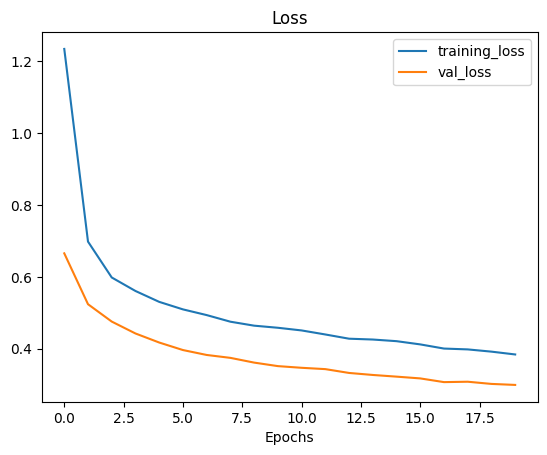

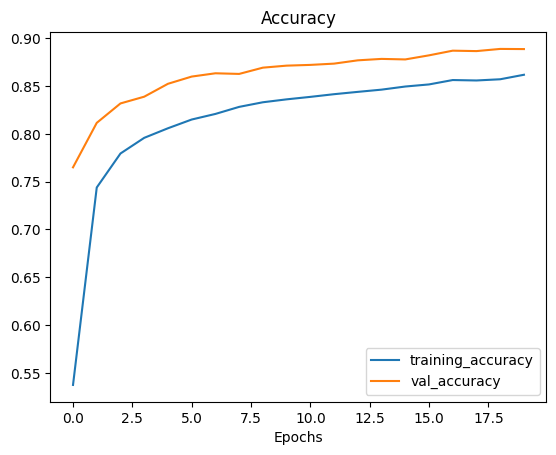

In [85]:
#plot_results("", history)
plot_loss_curves(history)

## Evaluate the model

In [86]:
eval = model.evaluate(test_batches, verbose=1)

for name, value in zip(model.metrics_names, eval):
  print("%s: %.10f" % (name, value))

10/10 [==============================] - 0s 46ms/step - loss: 0.3268 - accuracy: 0.8816
loss: 0.3267770410
accuracy: 0.8816000223


## Prediction

In [87]:
for test_images, test_labels in test_batches.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

predictions, predictions.shape, test_labels


32/32 [==============================] - 0s 3ms/step


(array([[1.74834313e-05, 8.15584031e-07, 3.63978073e-02, ...,
         1.82330098e-08, 1.47929941e-05, 1.99662850e-07],
        [8.46787543e-07, 1.22438575e-08, 1.23406025e-02, ...,
         4.74963922e-11, 4.71254310e-07, 2.30732478e-09],
        [4.74608078e-06, 6.26381052e-06, 8.97971518e-07, ...,
         3.79764140e-02, 2.21983919e-05, 9.60466623e-01],
        ...,
        [1.82585529e-04, 1.41826661e-06, 2.08532847e-02, ...,
         8.40690646e-08, 2.04046810e-04, 2.18345031e-06],
        [1.12485441e-05, 7.17943840e-06, 1.94303743e-06, ...,
         9.67071235e-01, 6.18265403e-05, 3.08435950e-02],
        [1.61202252e-02, 1.02833705e-02, 4.30063158e-01, ...,
         1.73726567e-05, 1.50683557e-03, 2.75108498e-04]], dtype=float32),
 (1024, 10),
 array([4, 4, 9, ..., 6, 7, 2], dtype=int64))

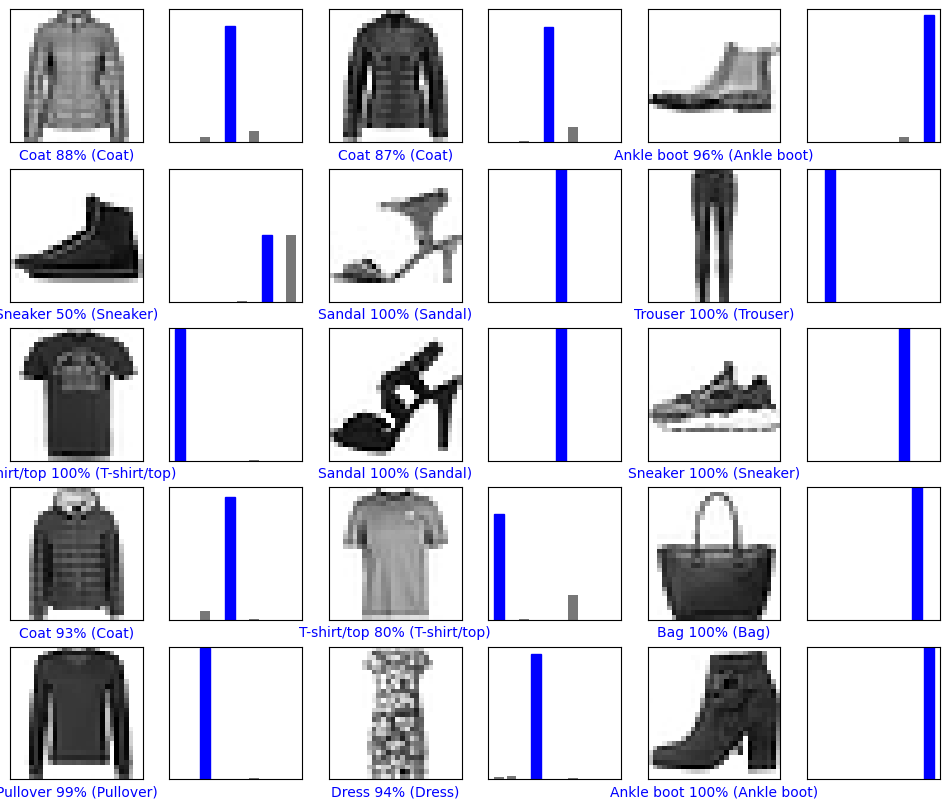

In [88]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images, class_names)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


## Create a Confusion Matrix

In [89]:
preds_labels = predictions.argmax(axis=1)

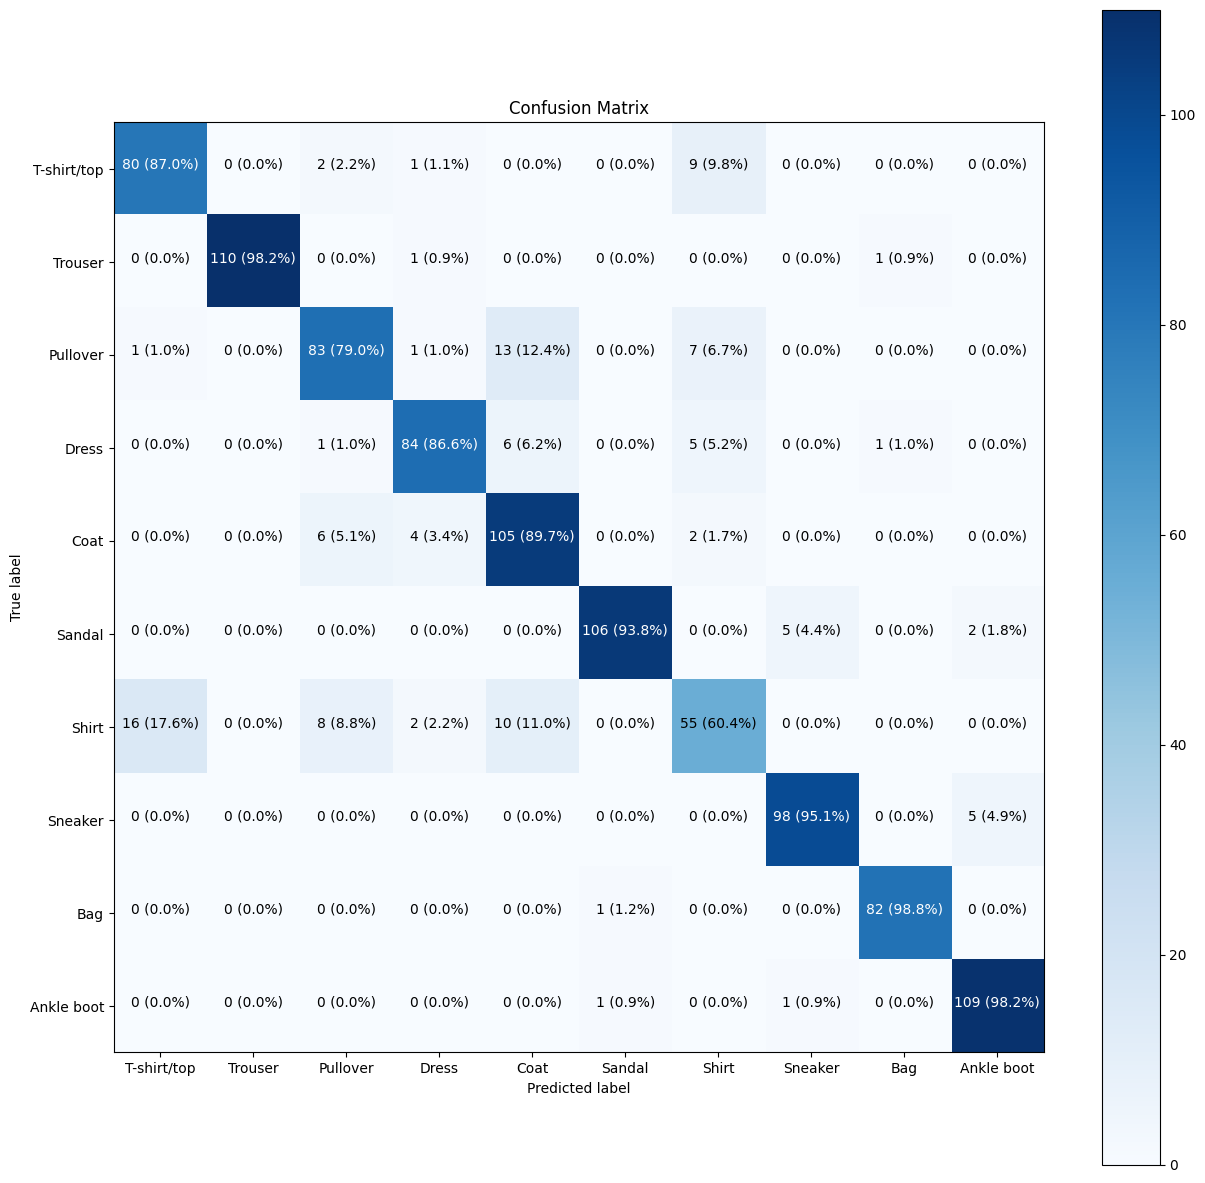

In [91]:
make_confusion_matrix(test_labels, preds_labels, classes=class_names, norm=True, figsize=(15, 15), text_size=10)